# Sigorta Masraflarının Tahmini

Bu not defterinde, sigorta masraflarını tahmin etmek için aşağıdaki makine öğrenmesi regresyon modelleri uygulanmıştır:  
- Polynomial Regression (Derece 2)  
- Support Vector Regression (SVR)  
- Decision Tree Regression  
- Random Forest Regression  

Veri ön işleme, model eğitimi, tahmin ve performans değerlendirmeleri adım adım gösterilmiştir.


# 🔍 Sigorta veri seti yükleniyor ve inceleniyor

Bu hücrede, sigorta harcamalarına ait örnek bir veri seti çevrim içi olarak yükleniyor ve veri çerçevesinin ilk 5 satırı görüntülenerek yapısı hakkında ön bilgi ediniliyor.


In [ ]:
# Gerekli kütüphaneler
import pandas as pd          # Veri işleme için
import numpy as np           # Sayısal işlemler için
import seaborn as sns        # Görselleştirme için
import matplotlib.pyplot as plt  # Grafik çizimi için

# Veri setini yükleme
url = "https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv"
df = pd.read_csv(url)        # CSV dosyasını internetten oku

# İlk 5 satıra bakalım
df.head()                    # Veri setinin ilk 5 satırını göster



,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


# 🧾 Veri yapısı ve özet bilgilerin incelenmesi

Bu bölümde veri setindeki sütunların veri tipleri, boş değer içerip içermediği ve temel istatistiksel özetleri görüntülenir. Ayrıca kategorik değişkenlerin alabileceği benzersiz değerler listelenir.


In [ ]:
# Veri tipi ve boş değer kontrolü
df.info()

# Temel istatistiksel bilgiler
df.describe()

# Kategorik sütunların benzersiz değerleri
for col in df.select_dtypes(include='object').columns:
    print(f"{col}: {df[col].unique()}")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
sex: ['female' 'male']
smoker: ['yes' 'no']
region: ['southwest' 'southeast' 'northwest' 'northeast']


# 📊 Değişkenler ile sigorta masrafları arasındaki ilişkiler

Bu bölümde yaş, cinsiyet ve sigara içme durumunun sigorta ücretleri üzerindeki etkisi grafiklerle incelenir. Scatter plot ve box plot’lar kullanılarak olası ilişkiler görselleştirilir.


<Axes: xlabel='age', ylabel='charges'>

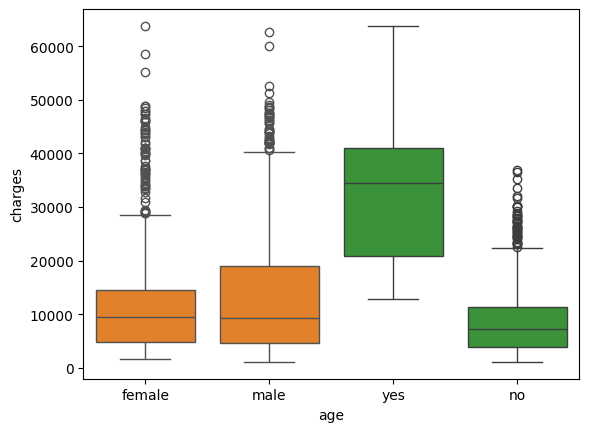

In [ ]:
# Yaş ve masraf ilişkisi
sns.scatterplot(x='age', y='charges', data=df)

# Cinsiyet ve ortalama ücret
sns.boxplot(x='sex', y='charges', data=df)

# Sigara içme durumu ve ücret
sns.boxplot(x='smoker', y='charges', data=df)


# 🔄 Kategorik değişkenlerin sayısal hale getirilmesi

Makine öğrenmesi modellerinde kullanılmak üzere, 'sex' ve 'smoker' sütunları Label Encoding ile sayısala dönüştürülür. 'region' sütunu ise One-Hot Encoding yöntemiyle kategorik değişkenlere ayrılarak modelin daha iyi öğrenmesi sağlanır.


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Kopya veri seti oluşturalım
df_encoded = df.copy()

# Label Encoding: 'sex' ve 'smoker' sütunlarını sayısala çeviriyoruz
le_sex = LabelEncoder()
le_smoker = LabelEncoder()

df_encoded['sex'] = le_sex.fit_transform(df_encoded['sex'])          # female:0, male:1
df_encoded['smoker'] = le_smoker.fit_transform(df_encoded['smoker']) # no:0, yes:1

# One-Hot Encoding: 'region' sütununu kategorik sütunlara ayırıyoruz, ilk kategori atlanıyor
df_encoded = pd.get_dummies(df_encoded, columns=['region'], drop_first=True)

# Son hali görelim
print(df_encoded.head())


   age  sex     bmi  children  smoker      charges  region_northwest  \
0   19    0  27.900         0       1  16884.92400             False   
1   18    1  33.770         1       0   1725.55230             False   
2   28    1  33.000         3       0   4449.46200             False   
3   33    1  22.705         0       0  21984.47061              True   
4   32    1  28.880         0       0   3866.85520              True   

   region_southeast  region_southwest  
0             False              True  
1              True             False  
2              True             False  
3             False             False  
4             False             False  


# 🎯 Özellikler ve hedef değişkenin belirlenmesi

Model eğitimi için bağımsız değişkenler (özellikler) ve bağımlı değişken (hedef) ayrılır. Veri, %80 eğitim ve %20 test olmak üzere rastgele bölünür.


In [ ]:
# Özellik ve hedef değişken ayrımı
X = df_encoded.drop("charges", axis=1)
y = df_encoded["charges"]

# Eğitim-test ayırımı
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


# ⚙️ Özelliklerin standartlaştırılması

Model performansını artırmak için sayısal özellikler standartlaştırılır. Eğitim verisine fit edilip hem eğitim hem test verisi aynı ölçeğe dönüştürülür.


In [ ]:
from sklearn.preprocessing import StandardScaler
#regresyon için
# Eğitim ve test verilerine ayrı ayrı scaler uygulamayız: önce fit, sonra transform yapılmalı
scaler = StandardScaler()

# Sadece X'e uyguluyoruz (y = charges değişmeyecek)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# 🤖 Polynomial Regression Modeli Eğitimi ve Değerlendirmesi

Bu aşamada, veriye 2. dereceden polinom özellikler eklenir ve Linear Regression modeli ile eğitim yapılır. Modelin tahmin performansı MAE, MSE, RMSE ve R² metrikleriyle değerlendirilir.


In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# 1. Polinom özellikler üret (derece=2)
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train_scaled)   # Eğitim verisine polinom dönüşümü uygula
X_test_poly = poly.transform(X_test_scaled)         # Test verisine polinom dönüşümü uygula

# 2. Modeli oluştur ve eğit
poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train)                # Modeli eğitim verisiyle eğit

# 3. Tahmin yap
y_pred_poly = poly_model.predict(X_test_poly)        # Test verisiyle tahmin yap

# 4. Performans metriklerini hesapla
mae_poly = mean_absolute_error(y_test, y_pred_poly)
mse_poly = mean_squared_error(y_test, y_pred_poly)
rmse_poly = np.sqrt(mse_poly)
r2_poly = r2_score(y_test, y_pred_poly)

# 5. Sonuçları yazdır
print("🔹 Polynomial Regression (Degree 2) Sonuçları:")
print(f"MAE:  {mae_poly:.2f}")
print(f"MSE:  {mse_poly:.2f}")
print(f"RMSE: {rmse_poly:.2f}")
print(f"R²:   {r2_poly:.4f}")


🔹 Polynomial Regression (Degree 2) Sonuçları:
MAE:  2729.50
MSE:  20712805.99
RMSE: 4551.13
R²:   0.8666


# 📈 Gerçek ve tahmin edilen değerlerin karşılaştırılması

Modelin tahminlerinin doğruluğunu görsel olarak değerlendirmek için gerçek ve tahmin edilen sigorta ücretleri scatter plot ile karşılaştırılır. Kırmızı kesikli çizgi ideal eşleşmeyi temsil eder.


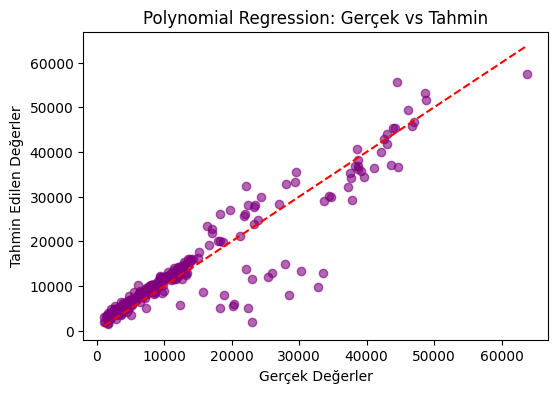

In [ ]:
# Gerçek vs Tahmin grafiği
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.scatter(y_test, y_pred_poly, alpha=0.6, color='purple')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Gerçek Değerler")
plt.ylabel("Tahmin Edilen Değerler")
plt.title("Polynomial Regression: Gerçek vs Tahmin")
plt.show()


# 🧩 Support Vector Regression (SVR) Modeli Eğitimi ve Değerlendirmesi

SVR modeli, hedef değişkeni (sigorta ücretleri) standartlaştırarak eğitilir ve test verisi üzerinde tahminler yapılır. Performans MAE, MSE, RMSE ve R² metrikleriyle ölçülür.


In [ ]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# 1. y'yi scale etmek için scaler tanımla
y_scaler = StandardScaler()
# y_train (reshape gerekiyor çünkü 1D array)
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1))  # sadece doğruluk için
# 2. SVR modelini tanımla ve eğit (C parametresi eklendi)
svr_model = SVR(kernel='rbf', C=3)
svr_model.fit(X_train_scaled, y_train_scaled.ravel())  # ravel() → vektör haline getir
# 3. Tahmin yap
y_pred_svr_scaled = svr_model.predict(X_test_scaled)
# 4. Tahminleri geri eski skala'ya dönüştür
y_pred_svr = y_scaler.inverse_transform(y_pred_svr_scaled.reshape(-1, 1))
# 5. Performans metrikleri
mae_svr = mean_absolute_error(y_test, y_pred_svr)
mse_svr = mean_squared_error(y_test, y_pred_svr)
rmse_svr = np.sqrt(mse_svr)
r2_svr = r2_score(y_test, y_pred_svr)
print("🔹 Support Vector Regression (SVR) Sonuçları:")
print(f"MAE:  {mae_svr:.2f}")
print(f"MSE:  {mse_svr:.2f}")
print(f"RMSE: {rmse_svr:.2f}")
print(f"R²:   {r2_svr:.4f}")


🔹 Support Vector Regression (SVR) Sonuçları:
MAE:  2443.02
MSE:  21158579.89
RMSE: 4599.85
R²:   0.8637


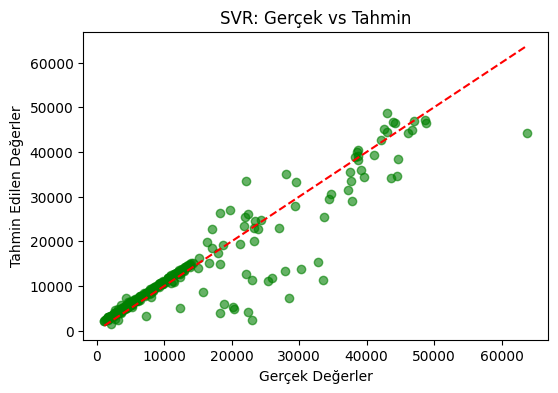

In [ ]:
plt.figure(figsize=(6,4))
plt.scatter(y_test, y_pred_svr, alpha=0.6, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Gerçek Değerler")
plt.ylabel("Tahmin Edilen Değerler")
plt.title("SVR: Gerçek vs Tahmin")
plt.show()


# 🌳 Decision Tree Regression Modeli Eğitimi ve Değerlendirmesi

Bu bölümde, maksimum derinliği 4 olan bir karar ağacı regresyon modeli eğitilir. Modelin performansı standart metriklerle (MAE, MSE, RMSE, R²) değerlendirilir.


In [ ]:
from sklearn.tree import DecisionTreeRegressor

# Modeli oluştur ve eğit (max_depth parametresi eklendi)
dt_model = DecisionTreeRegressor(random_state=42, max_depth=4)
dt_model.fit(X_train, y_train)

# Tahmin yap
y_pred_dt = dt_model.predict(X_test)

# Performans metrikleri
mae_dt = mean_absolute_error(y_test, y_pred_dt)
mse_dt = mean_squared_error(y_test, y_pred_dt)
rmse_dt = np.sqrt(mse_dt)
r2_dt = r2_score(y_test, y_pred_dt)

print("🔹 Decision Tree Regression Sonuçları:")
print(f"MAE:  {mae_dt:.2f}")
print(f"MSE:  {mse_dt:.2f}")
print(f"RMSE: {rmse_dt:.2f}")
print(f"R²:   {r2_dt:.4f}")


🔹 Decision Tree Regression Sonuçları:
MAE:  2697.77
MSE:  21093484.00
RMSE: 4592.76
R²:   0.8641


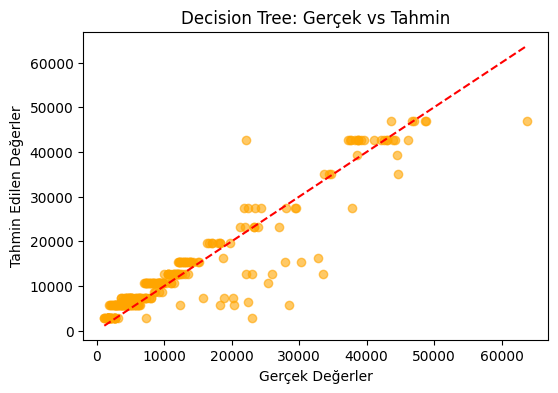

In [ ]:
plt.figure(figsize=(6,4))
plt.scatter(y_test, y_pred_dt, alpha=0.6, color='orange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Gerçek Değerler")
plt.ylabel("Tahmin Edilen Değerler")
plt.title("Decision Tree: Gerçek vs Tahmin")
plt.show()


# 🌲 Random Forest Regression Modeli Eğitimi ve Değerlendirmesi

Birden fazla karar ağacından oluşan Random Forest modeli oluşturulur ve eğitim verisiyle eğitilir. Modelin performansı MAE, MSE, RMSE ve R² metrikleriyle ölçülür.


In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Modeli oluştur ve eğit
rf_model = RandomForestRegressor(n_estimators=90, random_state=42)
rf_model.fit(X_train, y_train)

# Tahmin yap
y_pred_rf = rf_model.predict(X_test)

# Performans metrikleri
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("🔹 Random Forest Regression Sonuçları:")
print(f"MAE:  {mae_rf:.2f}")
print(f"MSE:  {mse_rf:.2f}")
print(f"RMSE: {rmse_rf:.2f}")
print(f"R²:   {r2_rf:.4f}")


🔹 Random Forest Regression Sonuçları:
MAE:  2553.55
MSE:  20908073.33
RMSE: 4572.53
R²:   0.8653


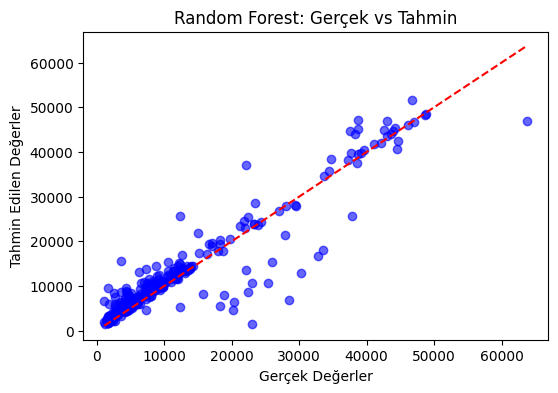

In [ ]:
plt.figure(figsize=(6,4))
plt.scatter(y_test, y_pred_rf, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Gerçek Değerler")
plt.ylabel("Tahmin Edilen Değerler")
plt.title("Random Forest: Gerçek vs Tahmin")
plt.show()


# 📊 Modellerin Performans Karşılaştırması

Farklı regresyon modellerinin MAE, MSE, RMSE ve R² metrikleri bazında karşılaştırıldığı özet tablo. Bu tablo, modellerin doğruluğunu hızlıca değerlendirmeye olanak sağlar.


In [ ]:
import pandas as pd

# Tablo verisi
results = {
    "Model": ["Polynomial Regression (Degree 2)", "Support Vector Regression",
              "Decision Tree Regression", "Random Forest Regression"],
    "MAE": [mae_poly, mae_svr, mae_dt, mae_rf],
    "MSE": [mse_poly, mse_svr, mse_dt, mse_rf],
    "RMSE": [rmse_poly, rmse_svr, rmse_dt, rmse_rf],
    "R²": [r2_poly, r2_svr, r2_dt, r2_rf]
}

results_df = pd.DataFrame(results)

# Tabloyu göster
results_df


,Model,MAE,MSE,RMSE,R²
0,Polynomial Regression (Degree 2),2729.500134,2.071281e+07,4551.132385,0.866583
1,Support Vector Regression,2443.020001,2.115858e+07,4599.845637,0.863712
2,Decision Tree Regression,2697.765431,2.109348e+07,4592.764310,0.864131
3,Random Forest Regression,2553.551068,2.090807e+07,4572.534672,0.865325


In [ ]:
# Regresyon Modellerinin Temel Çalışma Mantığı ve Farkları

1. **Polynomial Regression (2. Derece Polinom)**
   - Temelde doğrusal regresyonun bir uzantısıdır.
   - Veride doğrusal olmayan ilişkileri yakalamak için bağımsız değişkenlerin polinom terimlerini (x² gibi) modele ekler.
   - Model tüm veri üzerinde tek bir eğri veya yüzey fit etmeye çalışır.
   - Gürültülü verilere karşı hassastır; yüksek dereceli polinom aşırı öğrenmeye (overfitting) neden olabilir.

2. **Support Vector Regression (SVR)**
   - Veriyi doğrudan modellemek yerine, hedef değişkenin etrafında belirli bir tolerans (epsilon) aralığında kalacak şekilde en iyi uyumu sağlayan fonksiyonu bulur.
   - Kernel fonksiyonları (örneğin RBF) kullanarak doğrusal olmayan ilişkileri yüksek boyutlu uzayda doğrusal hale getirir.
   - Model, sadece sınırdaki (support vector) verilere dayanarak tahmin yapar, bu da onu gürültülü veriye karşı kısmen dayanıklı kılar.
   - Parametre ayarları (C ve epsilon) modelin gürültüye duyarlılığını ve esnekliğini kontrol eder.

3. **Decision Tree Regression (Karar Ağacı Regresyonu)**
   - Veri kümesini özelliklere göre dallara ayırarak karar kuralları oluşturur.
   - Her yaprak düğümünde, o düğüme düşen verilerin ortalama değeri tahmin olarak alınır.
   - Model çok kolay yorumlanabilir ve hızlıdır.
   - Ancak, çok derin ağaçlar gürültüye ve aşırı öğrenmeye çok duyarlıdır, çünkü tüm veri noktalarını mümkün olduğunca iyi ayırmaya çalışır.

4. **Random Forest Regression**
   - Birden fazla karar ağacının (genellikle yüzlerce) oluşturulması ve sonuçlarının ortalaması alınması prensibine dayanır (ensemble learning).
   - Her ağaç, eğitim verisinin rastgele seçilmiş farklı bir alt kümesi ve özellik alt kümesi kullanılarak eğitilir (bagging yöntemi).
   - Bu rastgelelik ve çoklu model birleşimi, tek bir karar ağacının aşırı öğrenme ve gürültüye duyarlılığını büyük ölçüde azaltır.
   - Daha stabil ve genelleme yeteneği yüksek modeller üretir ancak yorumlanması Decision Tree kadar kolay değildir.

---

### Özet:
- **Polynomial Regression** tek bir modelle doğrusal olmayan eğriler oluşturur, ancak aşırı öğrenmeye ve gürültüye hassastır.
- **SVR** yalnızca kritik veriler (support vector) ile çalışır, kernel ile karmaşık ilişkileri yakalar ve gürültüye karşı görece dayanıklıdır.
- **Decision Tree** kolay yorumlanır ancak aşırı derinleşirse gürültüye aşırı uyum sağlar ve genelleme yapamaz.
- **Random Forest** birden çok karar ağacının kombinasyonu sayesinde gürültüyü azaltır, aşırı öğrenmeyi önler ve daha güvenilir tahminler üretir.

